In [1]:
%matplotlib inline

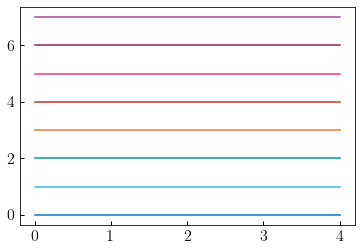

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from jax import numpy as jnp
from jax import jit as jjit
from jax import vmap
from jax import grad
from jax import random as jran
import os
import h5py
import time

mred = u"#d62728"
morange = u"#ff7f0e"
mgreen = u"#2ca02c"
mblue = u"#1f77b4"
mpurple = u"#9467bd"
plt.rc('font', family="serif")
plt.rc('font', size=22)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #necessary to use \dfrac
colors = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#CC3311", "#EE3377", '#882255', '#AA4499']
for i, x in enumerate(colors):
    plt.plot(np.ones(5)*i, color=x)

# Define some basic quantities

In [3]:
from diffstar.constants import TODAY
from diffstar.stars import fstar_tools

# Define our cosmci time array to make some predictions
#t_table = np.linspace(0.1, TODAY, 100)
# t_table = np.logspace(-1, np.log10(TODAY), 100)

t_table = np.linspace(1.0, TODAY, 20)
lgt = np.log10(t_table)
# Define some mass bins for predictions
# logm0_binmids = np.linspace(11.5, 13.5, 5)
logm0_binmids = np.linspace(11.0, 14.0, 7)

# logm0_binmids = np.linspace(12.0, 12.5, 3)
logm0_bin_widths = np.ones_like(logm0_binmids) * 0.1


# Define some useful quantities and masks for later
fstar_tdelay = 1.0
index_select, index_high = fstar_tools(t_table, fstar_tdelay=fstar_tdelay)


sm_loss_weight = jnp.where(t_table>2.0, 1.0, 1e10)
fstar_loss_MS_weight = jnp.where(t_table[index_select]>2.0, 1.0, 1e10)
fstar_loss_Q_weight = jnp.where(t_table[index_select]>5.0, 1.0, 1e10)

sm_loss_sel = np.arange(len(t_table))[t_table>1.0]
fstar_loss_MS_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>2.0]
fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>5.0]


In [4]:
logm0_binmids

array([11. , 11.5, 12. , 12.5, 13. , 13.5, 14. ])

# Generate some individual MAH histories with DiffmahPop

from diffmah.monte_carlo_halo_population import mc_halo_population
from diffstarpop.utils import get_t50_p50

Nhalos = 100
logmpeak_diffmahpop = []
mah_params_diffmahpop = []

log_mahs = np.zeros((len(logm0_binmids), Nhalos, len(t_table)))
for i, binmid in enumerate(logm0_binmids):
    _res = mc_halo_population(t_table, TODAY, binmid * np.ones(Nhalos))
    _mahparams = np.array([
        np.ones(Nhalos)*np.log10(TODAY),
        binmid * np.ones(Nhalos),
        _res.lgtc,
        np.ones(Nhalos)*3.5,
        _res.early_index,
        _res.late_index,
    ]).T
    
    logmpeak_diffmahpop.append(binmid * np.ones(Nhalos))
    mah_params_diffmahpop.append(_mahparams)
    
    log_mahs[i] = _res.log_mah
    

    
logmpeak_diffmahpop = np.concatenate(logmpeak_diffmahpop)
mah_params_diffmahpop = np.concatenate(mah_params_diffmahpop)
log_mahs_diffmahpop = np.concatenate(log_mahs)

halo_data_MC = mah_params_diffmahpop[:, np.array([1,2,4,5])].copy() # We only need logm, logtauc, early, late

t50, p50 = get_t50_p50(t_table, 10**log_mahs_diffmahpop, 0.5, log_mahs_diffmahpop[:,-1], window_length = 9)
#p50 = p50.reshape((len(logm0_binmids), N))

halo_data_MC_diffmahpop = halo_data_MC.copy()
p50_diffmahpop = p50.copy()

In [5]:
from diffmah.individual_halo_assembly import _calc_halo_history
_calc_halo_history_vmap = jjit(vmap(_calc_halo_history, in_axes=(None, *[0]*6)))
from diffstarpop.utils import get_t50_p50


data_path = "/Users/alarcon/Documents/diffmah_data/"
def get_mah_params(runname1):
    
    fitting_data = dict()

    fn = f"{data_path}{runname1}"
    with h5py.File(fn, 'r') as hdf:
        for key in hdf.keys():
            if key == 'halo_id':
                fitting_data[key] = hdf[key][...]
            else:
                fitting_data['fit_'+key] = hdf[key][...]
                
    mah_params = np.array([
        np.log10(fitting_data['fit_t0']),
        fitting_data['fit_logmp_fit'],
        fitting_data['fit_mah_logtc'],
        fitting_data['fit_mah_k'],
        fitting_data['fit_early_index'],
        fitting_data['fit_late_index'], 
    ]).T
    return mah_params
            
            
mah_params_SMDPL_arr = []  
# dmhdt = []
_log_mah = []
for i in range(10):
    runname1 = "run1_SMDPL_diffmah_default_%d.h5"%i
    _mah_params = get_mah_params(runname1)
    mah_params_SMDPL_arr.append(_mah_params)
    _res = _calc_halo_history_vmap(lgt, *_mah_params.T)
    # dmhdt.append(_res[0])
    _log_mah.append(_res[1])
    
mah_params_SMDPL = np.concatenate(mah_params_SMDPL_arr, axis=0)
mah_params_SMDPL = mah_params_SMDPL[:, np.array([1,2,4,5])]
"""
normal_values = (mah_params_SMDPL[:, 2] < 4.0)
normal_values &= (mah_params_SMDPL[:, 1] < 2.0)
mah_params_SMDPL = mah_params_SMDPL[normal_values]
"""
# dmhdt = np.concatenate(dmhdt, axis=0)
_log_mah = np.concatenate(_log_mah, axis=0)# [normal_values]

_logmpeak = _log_mah[:,-1]
t50, _p50 = get_t50_p50(t_table, 10**_log_mah, 0.5, _logmpeak, window_length = 101)

Nhalos = 100
halo_data_MC = []
p50 = []
log_mahs = []
logmpeak = []
for i in range(len(logm0_binmids)):
    _sel = (_logmpeak > logm0_binmids[i] - logm0_bin_widths[i]) & (_logmpeak < logm0_binmids[i] + logm0_bin_widths[i])
    print(_sel.sum())
    sel = np.random.choice(np.arange(len(_p50))[_sel], Nhalos, replace=False)
    halo_data_MC.append(mah_params_SMDPL[sel])
    p50.append(_p50[sel])
    log_mahs.append(_log_mah[sel])
    logmpeak.append(_logmpeak[sel])
halo_data_MC = np.concatenate(halo_data_MC, axis=0)
p50 = np.concatenate(p50, axis=0)
log_mahs = np.array(log_mahs)
logmpeak = np.concatenate(logmpeak, axis=0)
# log_mahs = log_mahs.reshape((len(logm0_binmids), Nhalos, len(t_table)))

_closest_m0 = np.argmin(abs(np.subtract.outer(halo_data_MC[:,0], logm0_binmids)),axis=1)
# halo_data_MC[:,0] = logm0_binmids[_closest_m0]

# halo_data_MC[:,0] = halo_data_MC_diffmahpop[:, 0].copy()

28218
10307
3718
1278
421
134
35


ValueError: Cannot take a larger sample than population when 'replace=False'

In [5]:
from diffstar.utils import _get_dt_array
from diffstar.fit_smah_helpers import get_header

from diffstar.stars import (
    _get_bounded_sfr_params, 
    _get_unbounded_sfr_params,
    _get_unbounded_sfr_params_vmap,
    _get_bounded_sfr_params_vmap,
)
from diffstar.quenching import _get_bounded_q_params, _get_unbounded_q_params, _get_bounded_q_params_vmap, _get_unbounded_q_params_vmap

from diffmah.individual_halo_assembly import _calc_halo_history
from diffstarpop.utils import get_t50_p50




_calc_halo_history_vmap = jjit(vmap(_calc_halo_history, in_axes=(None, *[0]*6)))

path = "/Users/alarcon/Documents/diffmah_data/SMDPL/"
runname = "run1_SMDPL_diffstar_default_%i.h5"

def get_mah_params(runname, data_path=path):

    fitting_data = dict()

    fn = os.path.join(data_path, runname)
    with h5py.File(fn, "r") as hdf:
        for key in hdf.keys():
            if key == "halo_id":
                fitting_data[key] = hdf[key][...]
            else:
                fitting_data["fit_" + key] = hdf[key][...]

    mah_params = np.array(
        [
            np.log10(fitting_data["fit_t0"]),
            fitting_data["fit_logmp_fit"],
            fitting_data["fit_mah_logtc"],
            fitting_data["fit_mah_k"],
            fitting_data["fit_early_index"],
            fitting_data["fit_late_index"],
        ]
    ).T
    return mah_params

def get_sfh_params(run_name):
    sfr_fitdata = dict()

    fn = os.path.join(path, run_name)
    with h5py.File(fn, "r") as hdf:
        for key in hdf.keys():
            sfr_fitdata[key] = hdf[key][...]

    colnames = get_header()[1:].strip().split()
    sfr_colnames = colnames[1:6]
    q_colnames = colnames[6:10]

    u_fit_params = np.array([sfr_fitdata[key] for key in sfr_colnames + q_colnames]).T
    u_sfr_fit_params = np.array([sfr_fitdata[key] for key in sfr_colnames]).T
    u_q_fit_params = np.array([sfr_fitdata[key] for key in q_colnames]).T

    sfr_fit_params = _get_bounded_sfr_params_vmap(*u_sfr_fit_params.T)
    q_fit_params = _get_bounded_q_params_vmap(*u_q_fit_params.T)
    
    sfr_fit_params = np.array([np.array(x) for x in sfr_fit_params]).T
    q_fit_params = np.array([np.array(x) for x in q_fit_params]).T

    fit_params = np.concatenate((sfr_fit_params, q_fit_params), axis=1)
    
    return u_fit_params, fit_params


def calculate_histories():
    """
    fstar_tdelay = 1.0
    index_select, index_high = fstar_tools(tarr, fstar_tdelay=fstar_tdelay)
    
    dmhdt = []
    log_mah = []
    mstar = []
    sfr = []
    fstar = []
    """
    tarr = np.linspace(0.1, TODAY, 100)

    dt = _get_dt_array(tarr)
    lgt = np.log10(tarr)

    
    log_mah = []
    mah_params_arr = []
    u_fit_params_arr = []
    fit_params_arr = []
    for i in range(576):
        runname = "run1_SMDPL_diffmah_default_%d.h5" % i
        mah_params = get_mah_params(runname)

        runname = "run1_SMDPL_diffstar_default_%i.h5" % i
        u_fit_params, fit_params = get_sfh_params(runname)

        mpeak = mah_params[:,1]
        mh_trans = 12.0
        weight = np.where(mah_params[:,1] > mh_trans, 1.0, 10**(0.82*(mah_params[:,1] - mh_trans)))
        rand = np.random.uniform(size=len(mpeak))
        mask = rand < weight
        
        mah_params = mah_params[mask]
        u_fit_params = u_fit_params[mask]
        fit_params = fit_params[mask]
        
        mah_params_arr.append(mah_params)
        u_fit_params_arr.append(u_fit_params)
        fit_params_arr.append(fit_params)
        print(i, len(mah_params))
        
        _res = _calc_halo_history_vmap(lgt, *mah_params.T)
        log_mah.append(_res[1])

    log_mah = np.concatenate(log_mah)
    p50 = get_t50_p50(tarr, 10**log_mah, 0.5, log_mah[:,-1], window_length = 101)[1]
    mah_params_arr = np.concatenate(mah_params_arr)
    u_fit_params_arr = np.concatenate(u_fit_params_arr)
    fit_params_arr = np.concatenate(fit_params_arr)
    return mah_params_arr, u_fit_params_arr, fit_params_arr, p50

mah_params_arr, u_fit_params_arr, fit_params_arr, p50_arr = calculate_histories()

0 3269
1 2993
2 3095
3 3002
4 3199
5 3201
6 3134
7 3030
8 3439
9 3272
10 3251
11 3364
12 3156
13 3252
14 3335
15 3165
16 3459
17 3487
18 3771
19 3669
20 3608
21 3554
22 3271
23 3493
24 3110
25 3110
26 3170
27 4104
28 2213
29 3187
30 3276
31 3137
32 3280
33 3111
34 3365
35 3246
36 3145
37 3146
38 3194
39 3264
40 3518
41 3504
42 3443
43 3448
44 3433
45 3460
46 3569
47 3405
48 3096
49 3220
50 3231
51 3090
52 3249
53 3239
54 3217
55 3131
56 3213
57 3191
58 3278
59 3182
60 3177
61 3044
62 3228
63 3104
64 3418
65 3626
66 3341
67 3426
68 3623
69 3411
70 3656
71 3464
72 3157
73 3985
74 2506
75 3163
76 3080
77 3219
78 3161
79 3029
80 3277
81 3234
82 3233
83 3241
84 3173
85 3132
86 3172
87 3240
88 3399
89 3633
90 3511
91 3518
92 3419
93 3465
94 3499
95 3510
96 3318
97 3131
98 3147
99 3136
100 3244
101 3045
102 3420
103 3005
104 3272
105 3325
106 3165
107 3280
108 3227
109 3265
110 3233
111 3391
112 3679
113 3577
114 3528
115 3636
116 3512
117 3605
118 3617
119 3477
120 3277
121 3283
122 3205
123

In [6]:
logmpeak = mah_params_arr[:,1]

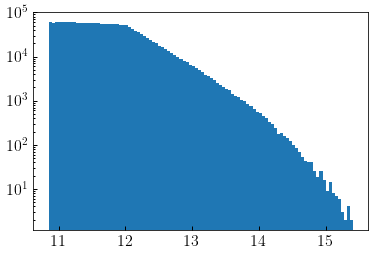

In [7]:
plt.hist(logmpeak, 100)
plt.yscale('log')
plt.show()

In [8]:
from diffstarpop.monte_carlo_diff_halo_population import (
    sm_sfr_history_diffstar_scan_XsfhXmah_vmap,
    sm_sfr_history_diffstar_scan_MS_XsfhXmah_vmap,
    _jax_get_dt_array

)
def calculate_SMDPL_sumstats(
    t_table,
    logm0_binmids,
    logm0_bin_widths,
    mah_params, 
    fit_params, 
    p50,
):
    logmpeak = mah_params[:, 1]

    lgt = np.log10(t_table)

    fstar_tdelay = 1.0
    index_select, index_high = fstar_tools(t_table, fstar_tdelay=fstar_tdelay)
    dt = _jax_get_dt_array(t_table)

    stats = []
    for i in range(len(logm0_binmids)):

        print("Calculating m0=[%.2f, %.2f]"%(logm0_binmids[i] - logm0_bin_widths[i], logm0_binmids[i] + logm0_bin_widths[i]))
        sel = (logmpeak > logm0_binmids[i] - logm0_bin_widths[i]) & (logmpeak < logm0_binmids[i] + logm0_bin_widths[i])
        print("Nhalos:", sel.sum())
        _res = sm_sfr_history_diffstar_scan_XsfhXmah_vmap(
            t_table,
            lgt,
            dt,
            mah_params[sel][:, [1,2,4,5]],
            fit_params[sel][:,[0,1,2,4]].copy(),
            fit_params[sel][:,[5,6,7,8]].copy(),
            index_select,
            index_high,
            fstar_tdelay,
        )
        
        (
            mstar_histories,
            sfr_histories,
            fstar_histories,
        ) = _res
        
        ssfr = sfr_histories / mstar_histories
        weights_quench_bin = jnp.where(ssfr > 1e-11, 1.0, 0.0)
        
        _stats = calculate_sumstats_bin(
            mstar_histories, 
            sfr_histories, 
            p50[sel], 
            weights_quench_bin
        )
        stats.append(_stats)

    print("Reshaping results")
        
    new_stats = []
    nres = len(_stats)
    for j in range(nres):
        _new_stats = []
        for i in range(len(logm0_binmids)):
            _new_stats.append(stats[i][j])
        new_stats.append(np.array(_new_stats))


    np.save("/Users/alarcon/Documents/diffmah_data/SMDPL_sfh_sumstats.npy", new_stats)
    return new_stats



def calculate_sumstats_bin(
    mstar_histories, sfr_histories, p50, weights_MS
):

    weights_Q = 1.0 - weights_MS

    # Clip weights. When all weights in a time
    # step are 0, Nans will occur in gradients.
    eps = 1e-10
    weights_Q = jnp.clip(weights_Q, eps, None)
    weights_MS = jnp.clip(weights_MS, eps, None)

    weights_early = jnp.where(p50 < 0.5, 1.0, 0.0)
    weights_late = 1.0 - weights_early
    weights_early = jnp.clip(weights_early, eps, None)
    weights_late = jnp.clip(weights_late, eps, None)

    mstar_histories = jnp.where(mstar_histories > 0.0, jnp.log10(mstar_histories), 0.0)
    sfr_histories = jnp.where(sfr_histories > 0.0, jnp.log10(sfr_histories), 0.0)
    # fstar_histories = jnp.where(fstar_histories > 0.0, jnp.log10(fstar_histories), 0.0)

    mean_sm = jnp.average(mstar_histories, axis=0)
    mean_sfr_MS = jnp.average(sfr_histories, weights=weights_MS, axis=0)
    mean_sfr_Q = jnp.average(sfr_histories, weights=weights_Q, axis=0)

    mean_sm_early = jnp.average(mstar_histories, weights=weights_early, axis=0)
    mean_sm_late = jnp.average(mstar_histories, weights=weights_late, axis=0)

    variance_sm = jnp.average(
        (mstar_histories - mean_sm[None, :]) ** 2, axis=0,
    )

    variance_sfr_MS = jnp.average(
        (sfr_histories - mean_sfr_MS[None, :]) ** 2, weights=weights_MS, axis=0,
    )
    variance_sfr_Q = jnp.average(
        (sfr_histories - mean_sfr_Q[None, :]) ** 2, weights=weights_Q, axis=0,
    )
    variance_sm_early = jnp.average(
        (mstar_histories - mean_sm[None, :]) ** 2, weights=weights_early, axis=0,
    )
    variance_sm_late = jnp.average(
        (mstar_histories - mean_sm[None, :]) ** 2, weights=weights_late, axis=0,
    )

    NHALO_MS = jnp.sum(weights_MS, axis=0)
    NHALO_Q = jnp.sum(weights_Q, axis=0)
    quench_frac = NHALO_Q / (NHALO_Q + NHALO_MS)

    mean_sfr_Q = jnp.where(quench_frac == 0.0, 0.0, mean_sfr_Q)
    variance_sfr_Q = jnp.where(quench_frac == 0.0, 0.0, variance_sfr_Q)
    mean_sfr_MS = jnp.where(quench_frac == 1.0, 0.0, mean_sfr_MS)
    variance_sfr_MS = jnp.where(quench_frac == 1.0, 0.0, variance_sfr_MS)

    NHALO_MS_early = jnp.sum(weights_MS * weights_early[:, None], axis=0)
    NHALO_Q_early = jnp.sum(weights_Q * weights_early[:, None], axis=0)
    quench_frac_early = NHALO_Q_early / (NHALO_Q_early + NHALO_MS_early)

    NHALO_MS_late = jnp.sum(weights_MS * weights_late[:, None], axis=0)
    NHALO_Q_late = jnp.sum(weights_Q * weights_late[:, None], axis=0)
    quench_frac_late = NHALO_Q_late / (NHALO_Q_late + NHALO_MS_late)

    _out = (
        mean_sm,
        variance_sm,
        mean_sfr_MS,
        mean_sfr_Q,
        variance_sfr_MS,
        variance_sfr_Q,
        quench_frac,
        mean_sm_early,
        mean_sm_late,
        variance_sm_early,
        variance_sm_late,
        quench_frac_early,
        quench_frac_late,
    )
    return _out

MC_res_target = calculate_SMDPL_sumstats(
    t_table,
    logm0_binmids,
    logm0_bin_widths,
    mah_params_arr, 
    u_fit_params_arr, 
    p50_arr
)

MC_res_target = np.array(MC_res_target)

Calculating m0=[10.90, 11.10]
Nhalos: 264313
Calculating m0=[11.40, 11.60]
Nhalos: 251595
Calculating m0=[11.90, 12.10]
Nhalos: 221197
Calculating m0=[12.40, 12.60]
Nhalos: 81419
Calculating m0=[12.90, 13.10]
Nhalos: 27465
Calculating m0=[13.40, 13.60]
Nhalos: 8594
Calculating m0=[13.90, 14.10]
Nhalos: 2373
Calculating m0=[14.40, 14.60]
Nhalos: 474
Reshaping results


In [24]:
normal_values = (mah_params_arr[:, 4] < 4.5)
normal_values &= (mah_params_arr[:, 2] < 2.0)

Nhalos = 2000
halo_data_MC = []
p50 = []
for i in range(len(logm0_binmids)):
    _sel = (logmpeak > logm0_binmids[i] - logm0_bin_widths[i]) & (logmpeak < logm0_binmids[i] + logm0_bin_widths[i])
    _sel &= normal_values
    print(_sel.sum())
    sel = np.random.choice(np.arange(len(p50_arr))[_sel], Nhalos, replace=False)
    halo_data_MC.append(mah_params_arr[sel])
    p50.append(p50_arr[sel])
halo_data_MC = np.concatenate(halo_data_MC, axis=0)[:, np.array([1,2,4,5])]
p50 = np.concatenate(p50, axis=0)


260173
248408
218158
80336
27108
8472
2316


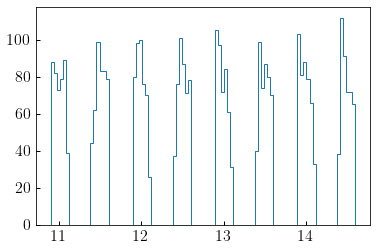

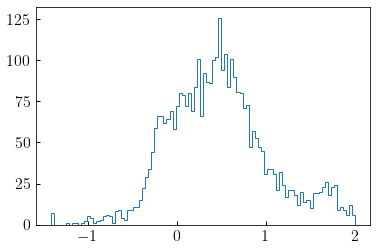

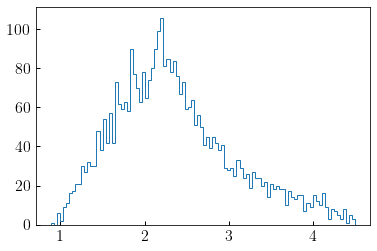

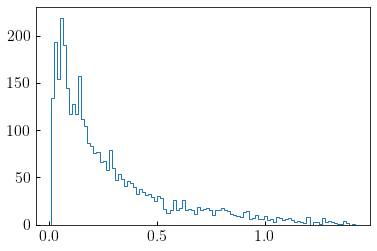

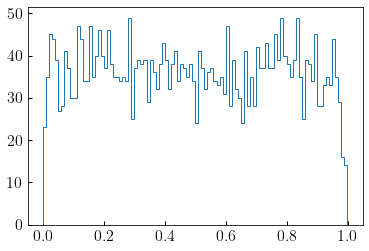

In [43]:
for i in range(4):
    # plt.hist(halo_data_MC_diffmahpop[:,i], 100, histtype='step')
    plt.hist(halo_data_MC[:,i], 100, histtype='step')
    plt.show()
    
plt.hist(p50, 100, histtype='step')
plt.show()

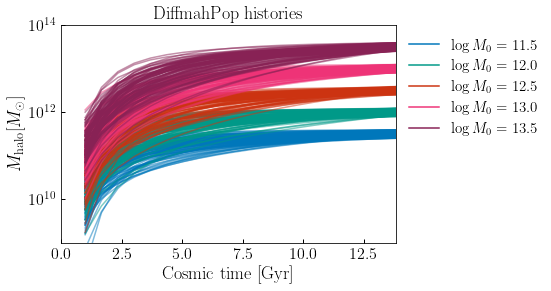

In [10]:
colors = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#CC3311", "#EE3377", '#882255', '#AA4499']
fig, ax = plt.subplots()

ax.plot(t_table, 10**log_mahs[0].T, colors[0], alpha=0.5)
ax.plot(t_table, 10**log_mahs[1].T, colors[2], alpha=0.5)
ax.plot(t_table, 10**log_mahs[2].T, colors[4], alpha=0.5)
ax.plot(t_table, 10**log_mahs[3].T, colors[5], alpha=0.5)
ax.plot(t_table, 10**log_mahs[4].T, colors[6], alpha=0.5)
ax.set_yscale('log')
ax.set_ylim(1e9, 1e14)
ax.set_xlim(0, TODAY)
ax.set_xlabel('Cosmic time [Gyr]')
ax.set_ylabel(r'$M_{\rm halo} [M_\odot]$')
ax.set_title("DiffmahPop histories")

legend_elements = [
    Line2D([0], [0], color=colors[0], label=r'$\log M_0 = %.1f$'%logm0_binmids[0]),
    Line2D([0], [0], color=colors[2], label=r'$\log M_0 = %.1f$'%logm0_binmids[1]),
    Line2D([0], [0], color=colors[4], label=r'$\log M_0 = %.1f$'%logm0_binmids[2]),
    Line2D([0], [0], color=colors[5], label=r'$\log M_0 = %.1f$'%logm0_binmids[3]),
    Line2D([0], [0], color=colors[6], label=r'$\log M_0 = %.1f$'%logm0_binmids[4]),
]
ax.legend(handles=legend_elements, loc=2, bbox_to_anchor=(1,1,))

plt.show()

### Get the default DiffstarPOP parameters for quenched and main sequence populations

In [10]:
from diffstarpop.pdf_quenched import DEFAULT_SFH_PDF_QUENCH_PARAMS
from diffstarpop.pdf_mainseq import DEFAULT_SFH_PDF_MAINSEQ_PARAMS

DEFAULT_SFH_PDF_QUENCH_PARAMS, DEFAULT_SFH_PDF_MAINSEQ_PARAMS

(OrderedDict([('frac_quench_x0', 11.86),
              ('frac_quench_k', 1.611),
              ('frac_quench_ylo', -0.872),
              ('frac_quench_yhi', 2.139),
              ('mean_ulgm_quench_ylo', 11.54),
              ('mean_ulgm_quench_yhi', 12.08),
              ('mean_ulgy_quench_ylo', 0.481),
              ('mean_ulgy_quench_yhi', -0.223),
              ('mean_ul_quench_ylo', -1.274),
              ('mean_ul_quench_yhi', 1.766),
              ('mean_utau_quench_ylo', 55.48),
              ('mean_utau_quench_yhi', -66.54),
              ('mean_uqt_quench_ylo', 1.744),
              ('mean_uqt_quench_yhi', 0.042),
              ('mean_uqs_quench_ylo', -2.979),
              ('mean_uqs_quench_yhi', 3.52),
              ('mean_udrop_quench_ylo', -0.508),
              ('mean_udrop_quench_yhi', -3.785),
              ('mean_urej_quench_ylo', 2.139),
              ('mean_urej_quench_yhi', -3.043),
              ('chol_ulgm_ulgm_quench_ylo', -1.645),
              ('chol_ulgm_ulg

### Get the default DiffstarPOP assembly bias parameters

In [11]:
from diffstarpop.pdf_model_assembly_bias_shifts import DEFAULT_R_MAINSEQ_PARAMS, DEFAULT_R_QUENCH_PARAMS

DEFAULT_R_MAINSEQ_PARAMS, DEFAULT_R_QUENCH_PARAMS

(OrderedDict([('R_ulgm_mainseq_ylo', -0.558),
              ('R_ulgm_mainseq_yhi', 0.575),
              ('R_ulgy_mainseq_ylo', -1.227),
              ('R_ulgy_mainseq_yhi', 2.171),
              ('R_ul_mainseq_ylo', 5.164),
              ('R_ul_mainseq_yhi', -3.384),
              ('R_utau_mainseq_ylo', 5.828),
              ('R_utau_mainseq_yhi', -5.587)]),
 OrderedDict([('R_Fquench', 0.994),
              ('R_ulgm_quench_ylo', -1.264),
              ('R_ulgm_quench_yhi', 0.44),
              ('R_ulgy_quench_ylo', -0.165),
              ('R_ulgy_quench_yhi', -1.083),
              ('R_ul_quench_ylo', 5.653),
              ('R_ul_quench_yhi', -4.126),
              ('R_utau_quench_ylo', 5.613),
              ('R_utau_quench_yhi', -6.922),
              ('R_uqt_quench_ylo', 0.19),
              ('R_uqt_quench_yhi', 0.191),
              ('R_uqs_quench_ylo', 2.124),
              ('R_uqs_quench_yhi', -2.699),
              ('R_udrop_quench_ylo', 1.071),
              ('R_udrop_quench_yh

# Draw individual SFH histories 


In [12]:
from diffstarpop.monte_carlo_diff_halo_population import (
    draw_sfh_Q_vmap,
    draw_sfh_MS_vmap,
    draw_sfh_MIX_vmap,
    draw_sfh_MIX,
)


In [13]:
def dict_to_array(dictionary):
    return np.array(list(dictionary.values()))

In [14]:
n_histories = int(1e4)
ran_key = jran.PRNGKey(0)

t0 = time.time()
histories = draw_sfh_MIX_vmap(
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4),
    p50.reshape(len(logm0_binmids),Nhalos),
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    dict_to_array(DEFAULT_SFH_PDF_QUENCH_PARAMS),
    dict_to_array(DEFAULT_SFH_PDF_MAINSEQ_PARAMS),
    dict_to_array(DEFAULT_R_QUENCH_PARAMS),
    dict_to_array(DEFAULT_R_MAINSEQ_PARAMS),
)
t1 = time.time()
print(t1-t0)

8.89473295211792


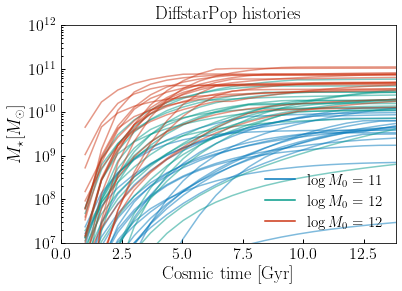

In [15]:
fig, ax = plt.subplots()

choice = np.random.choice(len(histories[0][0]), 20, replace=False)

ax.plot(t_table, histories[0][0][choice].T, colors[0], alpha=0.5)
ax.plot(t_table, histories[0][1][choice].T, colors[2], alpha=0.5)
ax.plot(t_table, histories[0][2][choice].T, colors[4], alpha=0.5)
ax.set_yscale('log')
ax.set_ylim(1e7, 1e12)
ax.set_xlim(0, TODAY)
ax.set_xlabel('Cosmic time [Gyr]')
ax.set_ylabel(r'$M_{\rm \star} [M_\odot]$')
ax.set_title("DiffstarPop histories")

legend_elements = [
    Line2D([0], [0], color=colors[0], label=r'$\log M_0 = %d$'%logm0_binmids[0]),
    Line2D([0], [0], color=colors[2], label=r'$\log M_0 = %d$'%logm0_binmids[1]),
    Line2D([0], [0], color=colors[4], label=r'$\log M_0 = %d$'%logm0_binmids[2]),
]
ax.legend(handles=legend_elements, loc=0)

plt.show()

In [17]:
histories[0][0]

DeviceArray([[6.0322260e+06, 7.2378328e+07, 2.6448526e+08, ...,
              1.7947632e+10, 1.8784297e+10, 1.8997776e+10],
             [3.0450090e+03, 1.7241736e+05, 1.6470039e+06, ...,
              1.9633544e+09, 2.0497801e+09, 2.0799067e+09],
             [1.4039047e+04, 1.4833497e+05, 7.7574700e+05, ...,
              1.2578202e+09, 1.4372890e+09, 1.6151444e+09],
             ...,
             [1.5552426e+07, 7.4094872e+07, 2.0599600e+08, ...,
              1.1850386e+10, 1.2505545e+10, 1.3065846e+10],
             [4.0751675e+05, 4.5527195e+06, 1.9139954e+07, ...,
              5.3119201e+09, 5.8895933e+09, 6.4463969e+09],
             [1.3482875e+07, 4.5801656e+07, 1.0628178e+08, ...,
              8.3339853e+09, 9.1570176e+09, 9.9483249e+09]],            dtype=float32)

# Calculate first and second order moments of Mstar, SFH with DiffstarPop drawing individual SFH histories


### Compare the calculations between two different `diffstar` kernel implementations using `vmap` or `scan` 

In [15]:
from diffstarpop.monte_carlo_diff_halo_population import (
    sumstats_sfh_Q_vmap,
    sumstats_sfh_MS_vmap,
    sumstats_sfh_MIX_vmap,
    sumstats_sfh_MIX_p50_vmap,
)


In [17]:
MC_res_target = np.load("/Users/alarcon/Documents/diffmah_data/SMDPL_sfh_sumstats.npy")

In [18]:
MC_res_target

array([[[ 5.40738487e+00,  6.51687145e+00,  7.15708733e+00, ...,
          9.33177662e+00,  9.35834026e+00,  9.38069534e+00],
        [ 6.31947613e+00,  7.50792646e+00,  8.20245838e+00, ...,
          1.02330418e+01,  1.02492304e+01,  1.02631340e+01],
        [ 7.12064457e+00,  8.37645531e+00,  9.10095501e+00, ...,
          1.06786985e+01,  1.06871462e+01,  1.06947870e+01],
        [ 7.81665230e+00,  9.08892632e+00,  9.78300190e+00, ...,
          1.08432665e+01,  1.08478107e+01,  1.08519068e+01],
        [ 8.44346905e+00,  9.70171547e+00,  1.02764187e+01, ...,
          1.08588104e+01,  1.08617764e+01,  1.08644381e+01]],

       [[ 2.55851269e+00,  1.43099153e+00,  9.54191625e-01, ...,
          1.88662216e-01,  1.83529750e-01,  1.79385185e-01],
        [ 1.95088685e+00,  1.16072583e+00,  8.31396103e-01, ...,
          1.00868255e-01,  9.51923430e-02,  9.10481811e-02],
        [ 1.50516176e+00,  9.18576896e-01,  6.65376484e-01, ...,
          5.95181212e-02,  5.75854890e-02,  5.60660

In [16]:
N_PDF_Q = len(DEFAULT_SFH_PDF_QUENCH_PARAMS)
N_PDF_MS = len(DEFAULT_SFH_PDF_MAINSEQ_PARAMS)
N_R_Q = len(DEFAULT_R_QUENCH_PARAMS)
N_R_MS = len(DEFAULT_R_MAINSEQ_PARAMS)

_loss_data = (
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4),
    p50.reshape(len(logm0_binmids),Nhalos),
    index_select,
    index_high,
    fstar_tdelay,
    MC_res_target
)

init_guess = np.concatenate((
    dict_to_array(DEFAULT_SFH_PDF_QUENCH_PARAMS),
    dict_to_array(DEFAULT_SFH_PDF_MAINSEQ_PARAMS),
    dict_to_array(DEFAULT_R_QUENCH_PARAMS),
    dict_to_array(DEFAULT_R_MAINSEQ_PARAMS),
))


In [220]:

n_histories = int(1e4)
ran_key = jran.PRNGKey(0)

t0 = time.time()
MC_res_init_guess = sumstats_sfh_MIX_p50_vmap(
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4),
    # halo_data_MC_diffmahpop.reshape(len(logm0_binmids),Nhalos,4),
    p50.reshape(len(logm0_binmids),Nhalos),
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    init_guess[0:N_PDF_Q],
    init_guess[N_PDF_Q:N_PDF_Q+N_PDF_MS],
    init_guess[N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
    init_guess[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
)
t1 = time.time()
print(t1-t0)

2.6680119037628174


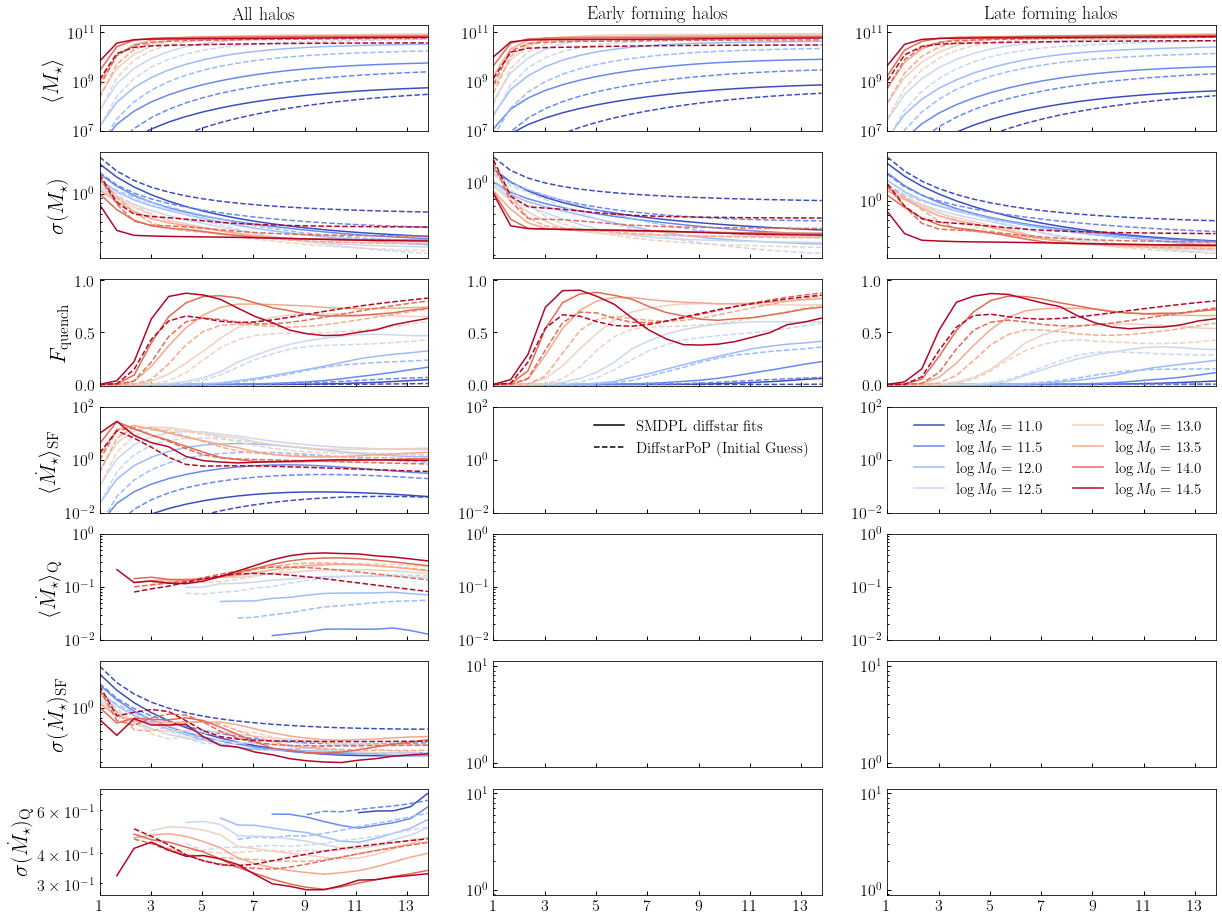

In [221]:
NM0 = len(logm0_binmids)
colors = plt.get_cmap("viridis")(np.linspace(0,1,NM0))
colors = plt.get_cmap("coolwarm")(np.linspace(0,1,NM0))

fontsize = 22
fig, ax = plt.subplots(7,3, figsize=(20,16), sharex=True, sharey=False)

lw = 1.5

for i in range(NM0):    
    
    ax[0,0].plot(t_table, 10**MC_res_target[0][i], ls="-", color=colors[i])
    ax[0,1].plot(t_table, 10**MC_res_target[7][i], ls="-", color=colors[i])
    ax[0,2].plot(t_table, 10**MC_res_target[8][i], ls="-", color=colors[i])
    
    ax[1,0].plot(t_table, np.sqrt(MC_res_target[1][i]), ls="-", color=colors[i])
    ax[1,1].plot(t_table, np.sqrt(MC_res_target[9][i]), ls="-", color=colors[i])
    ax[1,2].plot(t_table, np.sqrt(MC_res_target[10][i]), ls="-", color=colors[i])
    
    ax[2,0].plot(t_table, MC_res_target[6][i], ls="-", color=colors[i])
    ax[2,1].plot(t_table, MC_res_target[11][i], ls="-", color=colors[i])
    ax[2,2].plot(t_table, MC_res_target[12][i], ls="-", color=colors[i])

    mskQ = np.array(MC_res_target[6][i] > 0.01)
    mskSF = np.array(MC_res_target[6][i] < 0.99)
    ax[3,0].plot(t_table[mskSF], 10**MC_res_target[2][i][mskSF], ls="-", color=colors[i])
    ax[4,0].plot(t_table[mskQ], 10**MC_res_target[3][i][mskQ], ls="-", color=colors[i])

    ax[5,0].plot(t_table[mskSF], np.sqrt(MC_res_target[4][i])[mskSF], ls="-", color=colors[i])
    ax[6,0].plot(t_table[mskQ], np.sqrt(MC_res_target[5][i])[mskQ], ls="-", color=colors[i])
    
    ################################
    
    ax[0,0].plot(t_table, 10**MC_res_init_guess[0][i], ls="--", color=colors[i], lw=lw)
    ax[0,1].plot(t_table, 10**MC_res_init_guess[7][i], ls="--", color=colors[i], lw=lw)
    ax[0,2].plot(t_table, 10**MC_res_init_guess[8][i], ls="--", color=colors[i], lw=lw)
    
    ax[1,0].plot(t_table, np.sqrt(MC_res_init_guess[1][i]), ls="--", color=colors[i], lw=lw)
    ax[1,1].plot(t_table, np.sqrt(MC_res_init_guess[9][i]), ls="--", color=colors[i], lw=lw)
    ax[1,2].plot(t_table, np.sqrt(MC_res_init_guess[10][i]), ls="--", color=colors[i], lw=lw)
    
    ax[2,0].plot(t_table, MC_res_init_guess[6][i], ls="--", color=colors[i], lw=lw)
    ax[2,1].plot(t_table, MC_res_init_guess[11][i], ls="--", color=colors[i], lw=lw)
    ax[2,2].plot(t_table, MC_res_init_guess[12][i], ls="--", color=colors[i], lw=lw)

    mskQ = np.array(MC_res_init_guess[6][i] > 0.01)
    mskSF = np.array(MC_res_init_guess[6][i] < 0.99)
    ax[3,0].plot(t_table[mskSF], 10**MC_res_init_guess[2][i][mskSF], ls="--", color=colors[i], lw=lw)
    ax[4,0].plot(t_table[mskQ], 10**MC_res_init_guess[3][i][mskQ], ls="--", color=colors[i], lw=lw)

    ax[5,0].plot(t_table[mskSF], np.sqrt(MC_res_init_guess[4][i])[mskSF], ls="--", color=colors[i], lw=lw)
    ax[6,0].plot(t_table[mskQ], np.sqrt(MC_res_init_guess[5][i])[mskQ], ls="--", color=colors[i], lw=lw)

ax[0,0].set_title("All halos")
ax[0,1].set_title("Early forming halos")
ax[0,2].set_title("Late forming halos")

ax[0,0].set_ylabel(r'$\langle M_\star\rangle$', fontsize=fontsize)
ax[1,0].set_ylabel(r'$\sigma( M_\star)$', fontsize=fontsize)
ax[2,0].set_ylabel(r'$F_{\rm quench}$', fontsize=fontsize)
ax[3,0].set_ylabel(r'$\langle \dot{M}_\star\rangle_{\rm{SF}}$', fontsize=fontsize)
ax[4,0].set_ylabel(r'$\langle \dot{M}_\star\rangle_{\rm{Q}}$', fontsize=fontsize)
ax[5,0].set_ylabel(r'$\sigma( \dot{M}_\star)_{\rm{SF}}$', fontsize=fontsize)
ax[6,0].set_ylabel(r'$\sigma( \dot{M}_\star)_{\rm{Q}}$', fontsize=fontsize)

for i in range(3):
    ax[0,i].set_yscale('log')
    ax[1,i].set_yscale('log')
    ax[0,i].set_ylim(1e7, 2e11)
    ax[2,i].set_ylim(-0.01,1.01)
    ax[3,i].set_yscale('log')
    ax[4,i].set_yscale('log')
    ax[3,i].set_ylim(1e-2, 1e2)
    ax[4,i].set_ylim(1e-2, 1e0)
    ax[5,i].set_yscale('log')
    ax[6,i].set_yscale('log')
    
ax[0,0].set_xlim(1.0, TODAY)
ax[0,0].set_xticks(np.arange(1,13.1,2))

legend_elements = [
    Line2D([0], [0], color=colors[i], label=r'$\log M_0 = %.1f$'%logm0_binmids[i])
    for i in range(NM0)
]
ax[3,2].legend(handles=legend_elements, loc=1, ncol=2)

legend_elements = [
    Line2D([0], [0], color='k', ls='-', label=r"SMDPL diffstar fits"),
    Line2D([0], [0], color='k', ls='--', label=r"DiffstarPoP (Initial Guess)"),
]
ax[3,1].legend(handles=legend_elements, loc=1, ncol=1)

#plt.savefig("SMDPL_diffstarpop_sumstats_initialguess.png", bbox_inches='tight', dpi=300)
# plt.savefig("SMDPL_diffstarpop_sumstats_extrapol.png", bbox_inches='tight', dpi=300)

plt.show()

In [55]:
from diffstarpop.fit_pop_helpers import (
    loss_p50, loss_p50_deriv, loss_p50_deriv_np,
)
from diffstarpop.utils import minimizer, minimize
from jax.example_libraries import optimizers as jax_opt


In [222]:
n_histories = int(1e3)
n_step = int(1e4)
step_size=0.01
params_init = init_guess.copy()

ran_key = jran.PRNGKey(np.random.randint(2**32))

loss_arr = np.zeros(n_step).astype("f4") + np.inf

opt_init, opt_update, get_params = jax_opt.adam(step_size)
opt_state = opt_init(params_init)

n_params = len(params_init)
params_arr = np.zeros((n_step, n_params)).astype("f4")

n_mah = 100
sampled_mahs_inds_arr = np.zeros((n_step, n_histories))
no_nan_grads_arr = np.zeros(n_step)
for istep in range(n_step):
    t0 = time.time()
    ran_key, subkey = jran.split(ran_key, 2)

    p = np.array(get_params(opt_state))

    loss = loss_p50(p, _loss_data, n_histories, ran_key)
    grads = loss_p50_deriv(p, _loss_data, n_histories, ran_key)
    
    no_nan_params = np.all(np.isfinite(p))
    no_nan_loss = np.isfinite(loss)
    no_nan_grads = np.all(np.isfinite(grads))
    if ~no_nan_params | ~no_nan_loss | ~no_nan_grads:
        # break
        if istep > 0:
            indx_best = np.nanargmin(loss_arr[:istep])
            best_fit_params = params_arr[indx_best]
            best_fit_loss = loss_arr[indx_best]
        else:
            best_fit_params = np.copy(p)
            best_fit_loss = 999.99
    else:
        params_arr[istep, :] = p
        loss_arr[istep] = loss
        opt_state = opt_update(istep, grads, opt_state)
        
    keys = jran.split(ran_key, 5)
    

    sampled_mahs_inds = jran.choice(
        keys[0], n_mah, shape=(n_histories,), replace=True
    )
    sampled_mahs_inds_arr[istep] = sampled_mahs_inds
    no_nan_grads_arr[istep] = ~no_nan_grads
    t1 = time.time()
    print(istep, loss, t1-t0, no_nan_grads)
    # if ~no_nan_grads:
    #     break
"""
indx_best = np.nanargmin(loss_arr)
best_fit_params = params_arr[indx_best]
loss = loss_arr[indx_best]
"""


0 0.70959574 8.321516036987305 True
1 0.65082717 6.184325933456421 False
2 0.61997676 6.178964853286743 False
3 0.6354626 6.047313928604126 True
4 0.5917463 6.077707767486572 True
5 0.53102887 6.062475919723511 False
6 0.52870786 6.107676029205322 False
7 0.57432973 6.039524793624878 False
8 0.50921893 6.131562948226929 True
9 0.5203452 6.1611857414245605 False
10 0.48961613 6.065623998641968 False
11 0.48061636 6.086574077606201 True
12 0.4377334 6.225549221038818 True
13 0.41556588 6.338064908981323 True
14 0.40082735 6.277150869369507 True
15 0.36947158 8.98295783996582 False
16 0.35451657 6.3420140743255615 True
17 0.31040305 6.085613965988159 True
18 0.31124237 6.125404119491577 True
19 0.279359 6.166190147399902 True
20 0.24531499 6.0369651317596436 False
21 0.24218972 6.1401708126068115 False
22 0.2487555 6.143571853637695 True
23 0.24578741 6.1899120807647705 True
24 0.22610909 6.04840087890625 True
25 0.21782134 6.16087794303894 False
26 0.2103802 6.751924991607666 True
27 0.1

218 0.06465232 6.0803399085998535 True
219 0.06343898 6.156167030334473 True
220 0.060482312 6.062666893005371 True
221 0.06093904 6.0945751667022705 True
222 0.059483066 6.059049129486084 True
223 0.062278572 6.1295459270477295 True
224 0.059385896 6.049966096878052 True
225 0.059991498 6.056018829345703 True
226 0.063351505 6.19766902923584 True
227 0.06356497 6.06051778793335 True
228 0.06008297 6.074609279632568 True
229 0.061520215 6.04115629196167 True
230 0.055840313 6.043380975723267 True
231 0.060422108 6.092161178588867 True
232 0.0703674 6.059345960617065 True
233 0.05674633 6.078014850616455 True
234 0.05886899 6.076356887817383 True
235 0.061896972 6.043617010116577 False
236 0.06343435 6.039605140686035 True
237 0.062384237 6.082081079483032 True
238 0.05904503 6.109913110733032 True
239 0.06055829 6.100945949554443 True
240 0.059486244 6.132565021514893 True
241 0.057612386 6.072916030883789 True
242 0.05801125 6.115265130996704 True
243 0.058896933 6.037219047546387 Tru

KeyboardInterrupt: 

In [57]:
params_init = best_fit_params.copy()


In [225]:
n_histories = int(1e4)
n_step = int(1e3)
step_size = 0.01


# ran_key = jran.PRNGKey(np.random.randint(2**32))
ran_key = jran.PRNGKey(0)

loss_arr = np.zeros(n_step).astype("f4") + np.inf

# opt_init, opt_update, get_params = jax_opt.adam(step_size)
# opt_state = opt_init(params_init)

n_params = len(params_init)
params_arr = np.zeros((n_step, n_params)).astype("f4")

n_mah = 100
sampled_mahs_inds_arr = np.zeros((n_step, n_histories))
no_nan_grads_arr = np.zeros(n_step)
for istep in range(n_step):
    t0 = time.time()
    ran_key, subkey = jran.split(ran_key, 2)

    p = np.array(get_params(opt_state))

    loss = loss_p50(p, _loss_data, n_histories, ran_key)
    grads = loss_p50_deriv(p, _loss_data, n_histories, ran_key)
    
    no_nan_params = np.all(np.isfinite(p))
    no_nan_loss = np.isfinite(loss)
    no_nan_grads = np.all(np.isfinite(grads))
    if ~no_nan_params | ~no_nan_loss | ~no_nan_grads:
        # break
        if istep > 0:
            indx_best = np.nanargmin(loss_arr[:istep])
            best_fit_params = params_arr[indx_best]
            best_fit_loss = loss_arr[indx_best]
        else:
            best_fit_params = np.copy(p)
            best_fit_loss = 999.99
    else:
        params_arr[istep, :] = p
        loss_arr[istep] = loss
        opt_state = opt_update(istep, grads, opt_state)
        
    keys = jran.split(ran_key, 5)
    

    sampled_mahs_inds = jran.choice(
        keys[0], n_mah, shape=(n_histories,), replace=True
    )
    sampled_mahs_inds_arr[istep] = sampled_mahs_inds
    no_nan_grads_arr[istep] = ~no_nan_grads
    t1 = time.time()
    print(istep, loss, t1-t0, no_nan_grads)
    # if ~no_nan_grads:
    #     break

"""
indx_best = np.nanargmin(loss_arr)
best_fit_params = params_arr[indx_best]
loss = loss_arr[indx_best]

"""

0 0.054355238 162.2103590965271 True
1 0.054163527 153.96399188041687 True
2 0.05417889 163.6386799812317 True
3 0.05445987 155.19908118247986 True
4 0.053335313 147.82703518867493 True
5 0.052423775 160.51338386535645 True
6 0.05213009 156.8335952758789 True
7 0.05345788 150.77278327941895 True
8 0.054359037 150.25439524650574 True
9 0.052946992 149.69345617294312 True
10 0.05293662 163.59215903282166 False
11 0.05212497 143.6086938381195 True
12 0.052857455 150.57353615760803 True
13 0.054237917 160.94901704788208 True
14 0.053609524 167.50942993164062 False
15 0.052738536 145.4363899230957 True
16 0.052559588 175.24214792251587 True
17 0.052623067 148.91089916229248 False
18 0.05318428 144.39830708503723 True
19 0.05326416 146.81840991973877 True
20 0.05217505 143.44985127449036 True


KeyboardInterrupt: 

In [226]:
indx_best2 = np.nanargmin(loss_arr)
best_fit_params2 = params_arr[indx_best2]
loss2 = loss_arr[indx_best2]

In [76]:
n_histories = int(5e3)
n_step = int(1e2)
step_size = 0.01


# ran_key = jran.PRNGKey(np.random.randint(2**32))
ran_key = jran.PRNGKey(0)

loss_arr = np.zeros(n_step).astype("f4") + np.inf

# opt_init, opt_update, get_params = jax_opt.adam(step_size)
# opt_state = opt_init(params_init)

n_params = len(params_init)
params_arr = np.zeros((n_step, n_params)).astype("f4")

n_mah = 100
sampled_mahs_inds_arr = np.zeros((n_step, n_histories))
no_nan_grads_arr = np.zeros(n_step)
for istep in range(n_step):
    t0 = time.time()
    ran_key, subkey = jran.split(ran_key, 2)

    p = np.array(get_params(opt_state))

    loss = loss_p50(p, _loss_data, n_histories, ran_key)
    grads = loss_p50_deriv(p, _loss_data, n_histories, ran_key)
    
    no_nan_params = np.all(np.isfinite(p))
    no_nan_loss = np.isfinite(loss)
    no_nan_grads = np.all(np.isfinite(grads))
    if ~no_nan_params | ~no_nan_loss | ~no_nan_grads:
        # break
        if istep > 0:
            indx_best = np.nanargmin(loss_arr[:istep])
            best_fit_params = params_arr[indx_best]
            best_fit_loss = loss_arr[indx_best]
        else:
            best_fit_params = np.copy(p)
            best_fit_loss = 999.99
    else:
        params_arr[istep, :] = p
        loss_arr[istep] = loss
        opt_state = opt_update(istep, grads, opt_state)
        
    keys = jran.split(ran_key, 5)
    

    sampled_mahs_inds = jran.choice(
        keys[0], n_mah, shape=(n_histories,), replace=True
    )
    sampled_mahs_inds_arr[istep] = sampled_mahs_inds
    no_nan_grads_arr[istep] = ~no_nan_grads
    t1 = time.time()
    print(istep, loss, t1-t0, no_nan_grads)
    # if loss < 0.05:
    #     break

"""
indx_best = np.nanargmin(loss_arr)
best_fit_params = params_arr[indx_best]
loss = loss_arr[indx_best]

"""

0 0.018539041 40.92223310470581 True
1 0.020497877 33.083258867263794 True
2 0.019654617 31.372318029403687 True
3 0.02087221 31.100286960601807 True
4 0.020715687 31.94072389602661 True
5 0.01873094 34.36488199234009 True
6 0.020600937 31.74677085876465 True
7 0.019209394 39.047439098358154 True
8 0.01972091 35.02100992202759 True
9 0.019371945 37.64165496826172 True
10 0.019859517 39.738121032714844 True
11 0.018634817 34.61252784729004 True
12 0.019148203 34.43887901306152 True
13 0.019522365 36.45312690734863 True
14 0.018894458 35.39856195449829 True
15 0.018491905 41.01181221008301 True
16 0.01901765 34.48942804336548 True
17 0.018161297 33.77324390411377 True
18 0.01928672 38.750288248062134 True
19 0.02056546 33.75440192222595 True
20 0.01987597 35.536927938461304 True
21 0.018495368 34.944334745407104 True
22 0.01779069 35.81099796295166 True
23 0.018025672 37.17343211174011 True
24 0.01982776 33.27502703666687 True
25 0.019161692 44.26388216018677 True
26 0.019138673 33.98938

'\nindx_best = np.nanargmin(loss_arr)\nbest_fit_params = params_arr[indx_best]\nloss = loss_arr[indx_best]\n\n'

In [77]:
indx_best3 = np.nanargmin(loss_arr)
best_fit_params3 = params_arr[indx_best3]
loss3 = loss_arr[indx_best3]

In [90]:
ran_key = jran.PRNGKey(0)
for istep in range(54):
    t0 = time.time()
    ran_key, subkey = jran.split(ran_key, 2)
    
loss = loss_p50(params_arr[istep], _loss_data, n_histories, ran_key)
grads = loss_p50_deriv(params_arr[istep], _loss_data, n_histories, ran_key)

In [ ]:
NAN_KEYS = jran.split(ran_key, 5)

In [59]:
import numpy as np
from numpy.random import RandomState
from jax import vmap
from jax import jit as jjit
from jax import numpy as jnp
from jax import random as jran
from collections import OrderedDict
from functools import partial

from diffstar.stars import (
    calculate_sm_sfr_fstar_history_from_mah,
    DEFAULT_SFR_PARAMS as DEFAULT_SFR_PARAMS_DICT,
    _get_unbounded_sfr_params,
    _integrate_sfr,
    compute_fstar,
    fstar_tools,
)
from diffstar.quenching import (
    DEFAULT_Q_PARAMS as DEFAULT_Q_PARAMS_DICT,
    _get_unbounded_q_params,
    quenching_function,
)
from diffstar.main_sequence import get_ms_sfh_from_mah_kern
from diffstar.utils import jax_np_interp, _jax_get_dt_array


from diffmah.individual_halo_assembly import _calc_halo_history

from diffstarpop.pdf_quenched import (
    get_smah_means_and_covs_quench,
    DEFAULT_SFH_PDF_QUENCH_PARAMS,
    frac_quench_vs_lgm0,
)
from diffstarpop.pdf_mainseq import get_smah_means_and_covs_mainseq, DEFAULT_SFH_PDF_MAINSEQ_PARAMS
from diffstarpop.pdf_model_assembly_bias_shifts import (
    DEFAULT_R_QUENCH_PARAMS,
    DEFAULT_R_MAINSEQ_PARAMS,
    _get_slopes_quench,
    _get_slopes_mainseq,
    _get_shift_to_PDF_mean,
)
from diffstarpop.star_wrappers import (
    sm_sfr_history_diffstar_scan_XsfhXmah_vmap,
    sm_sfr_history_diffstar_scan_MS_XsfhXmah_vmap,
)
from diffstarpop.utils import _tw_cuml_lax_kern


from functools import partial
from diffstarpop.star_wrappers import (
    sm_sfr_history_diffstar_scan_XsfhXmah_vmap,
    sm_sfr_history_diffstar_scan_MS_XsfhXmah_vmap,
)

@partial(jjit, static_argnames=["n_histories"])
def _fun(
    t_table,
    logmh,
    mah_params,
    p50,
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    pdf_parameters_MS=DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    R_model_params_MS=DEFAULT_R_MAINSEQ_PARAMS,
):
    lgt = jnp.log10(t_table)
    dt = _jax_get_dt_array(t_table)
    logmh = jnp.atleast_1d(logmh)

    (choice_key, quench_key, mainseq_key, fquench_key, ran_key) = jran.split(ran_key, 5)
    n_mah = len(mah_params)

    sampled_mahs_inds = jran.choice(
        choice_key, n_mah, shape=(n_histories,), replace=True
    )
    mah_params_sampled = mah_params[sampled_mahs_inds]
    p50_sampled = p50[sampled_mahs_inds]

    _res = get_smah_means_and_covs_mainseq(logmh, *pdf_parameters_MS)
    means_mainseq, covs_mainseq = _res
    means_mainseq = means_mainseq[0]
    covs_mainseq = covs_mainseq[0]

    R_vals_mainseq = _get_slopes_mainseq(logmh, *R_model_params_MS)
    R_vals_mainseq = jnp.array(R_vals_mainseq)[:, 0]
    shifts_mainseq = jnp.einsum("p,h->hp", R_vals_mainseq, (p50_sampled - 0.5))

    sfr_params_MS = jran.multivariate_normal(
        mainseq_key, means_mainseq, covs_mainseq, shape=(n_histories,)
    )
    sfr_params_MS = sfr_params_MS + shifts_mainseq
    # q_params_MS = jnp.ones_like(q_params_Q) * 10.0

    mstar_MS, sfr_MS, fstar_MS = sm_sfr_history_diffstar_scan_MS_XsfhXmah_vmap(
        t_table,
        lgt,
        dt,
        mah_params_sampled,
        sfr_params_MS,
        index_select,
        index_high,
        fstar_tdelay,
    )
    mstar_MS = jnp.where(mstar_MS>0.0, jnp.log10(mstar_MS), 0.0) 
    return (jnp.mean(mstar_MS) - 10.0)**2

_fun_deriv = jjit(grad(_fun, argnums=(9, 10)), static_argnames=["n_histories"])


In [66]:
binid = 3
_res = _fun(
    _loss_data[0],
    _loss_data[1][binid],
    _loss_data[2][binid],
    _loss_data[3][binid],
    n_histories,
    ran_key,
    _loss_data[4],
    _loss_data[5],
    _loss_data[6],
    p[N_PDF_Q:N_PDF_Q+N_PDF_MS],
    p[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
)

print(_res)

_res_grads = _fun_deriv(
    _loss_data[0],
    _loss_data[1][binid],
    _loss_data[2][binid],
    _loss_data[3][binid],
    n_histories,
    ran_key,
    _loss_data[4],
    _loss_data[5],
    _loss_data[6],
    p[N_PDF_Q:N_PDF_Q+N_PDF_MS],
    p[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
)

print(_res_grads)


0.36601254
(DeviceArray([-5.0228345e-03, -5.0228345e-03,  3.1189024e-01,
              3.1189024e-01, -9.0579391e-02, -9.0579391e-02,
             -9.8150112e-03, -9.8150112e-03, -1.9840196e-01,
             -1.9840196e-01, -1.1302834e-01, -1.1302834e-01,
             -2.0473240e-02, -2.0473240e-02, -2.6698029e-01,
             -2.6698029e-01,  6.3770282e-04,  6.3770282e-04,
             -1.0377981e-02, -1.0377981e-02, -1.9005980e-04,
             -1.9005980e-04,  1.1041158e-02,  1.1041158e-02,
             -5.9196786e-03, -5.9196786e-03,  1.1106974e-02,
              1.1106974e-02], dtype=float32), DeviceArray([-0.01634221, -0.01634221, -0.00705876, -0.00705876,
             -0.00464512, -0.00464512,  0.00011704,  0.00011704],            dtype=float32))


In [32]:
indx_best = np.nanargmin(loss_arr)
best_fit_params = params_arr[indx_best]
loss = loss_arr[indx_best]

In [227]:
_best_fit_params = best_fit_params2.copy()
n_histories = int(1e4)
ran_key = jran.PRNGKey(0)
i = 21
t0 = time.time()
MC_res_best_fit = sumstats_sfh_MIX_p50_vmap(
    t_table,
    logm0_binmids,
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4),
    p50.reshape(len(logm0_binmids),Nhalos),
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    _best_fit_params[0:N_PDF_Q],
    _best_fit_params[N_PDF_Q:N_PDF_Q+N_PDF_MS],
    _best_fit_params[N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
    _best_fit_params[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
)
t1 = time.time()
print(t1-t0)

3.0783588886260986


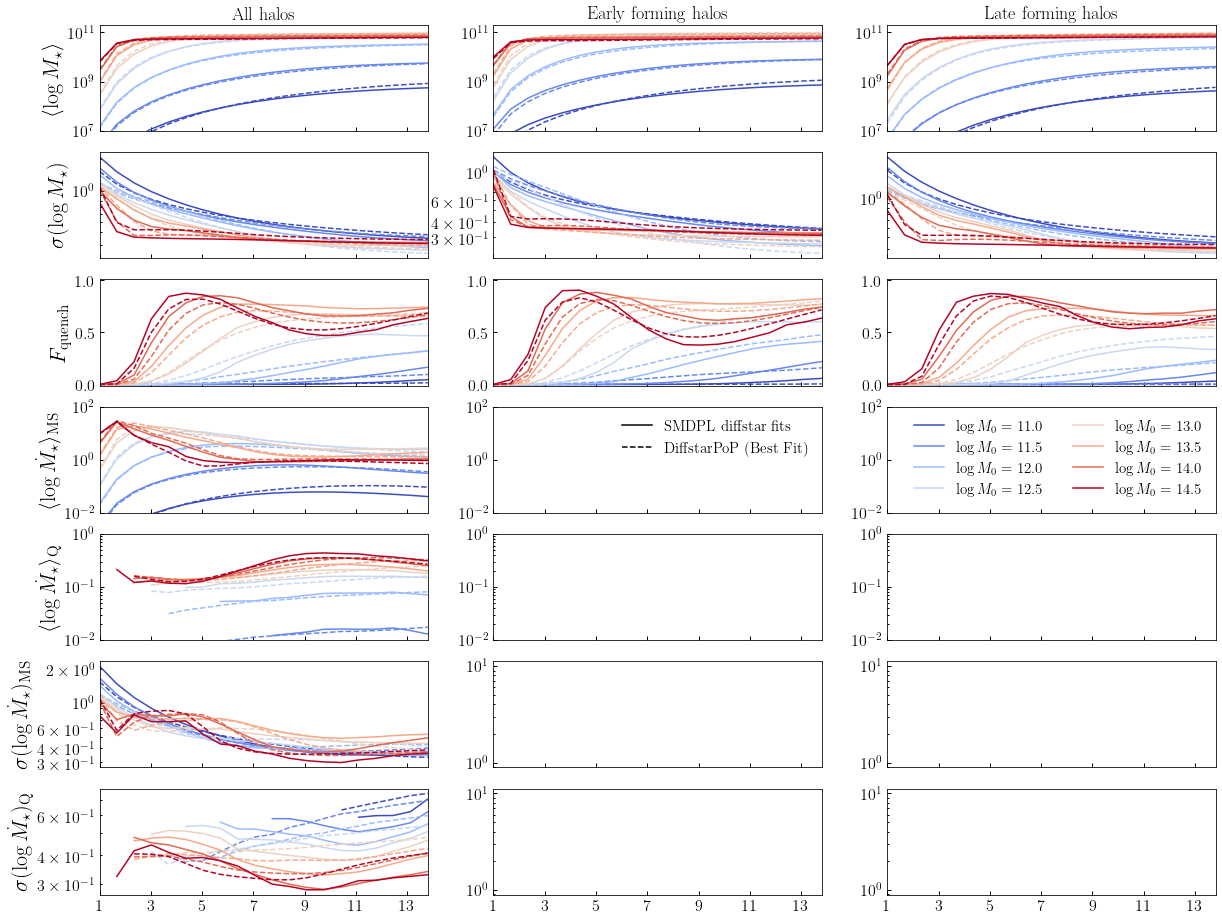

In [228]:
NM0 = len(logm0_binmids)
colors = plt.get_cmap("viridis")(np.linspace(0,1,NM0))
colors = plt.get_cmap("coolwarm")(np.linspace(0,1,NM0))

fontsize = 22
fig, ax = plt.subplots(7,3, figsize=(20,16), sharex=True, sharey=False)

lw = 1.5

for i in range(NM0):    
    
    ax[0,0].plot(t_table, 10**MC_res_target[0][i], ls="-", color=colors[i])
    ax[0,1].plot(t_table, 10**MC_res_target[7][i], ls="-", color=colors[i])
    ax[0,2].plot(t_table, 10**MC_res_target[8][i], ls="-", color=colors[i])
    
    ax[1,0].plot(t_table, np.sqrt(MC_res_target[1][i]), ls="-", color=colors[i])
    ax[1,1].plot(t_table, np.sqrt(MC_res_target[9][i]), ls="-", color=colors[i])
    ax[1,2].plot(t_table, np.sqrt(MC_res_target[10][i]), ls="-", color=colors[i])
    
    ax[2,0].plot(t_table, MC_res_target[6][i], ls="-", color=colors[i])
    ax[2,1].plot(t_table, MC_res_target[11][i], ls="-", color=colors[i])
    ax[2,2].plot(t_table, MC_res_target[12][i], ls="-", color=colors[i])

    mskQ = np.array(MC_res_target[6][i] > 0.01)
    mskSF = np.array(MC_res_target[6][i] < 0.99)
    ax[3,0].plot(t_table[mskSF], 10**MC_res_target[2][i][mskSF], ls="-", color=colors[i])
    ax[4,0].plot(t_table[mskQ], 10**MC_res_target[3][i][mskQ], ls="-", color=colors[i])

    ax[5,0].plot(t_table[mskSF], np.sqrt(MC_res_target[4][i])[mskSF], ls="-", color=colors[i])
    ax[6,0].plot(t_table[mskQ], np.sqrt(MC_res_target[5][i])[mskQ], ls="-", color=colors[i])
    
    ################################
    
    ax[0,0].plot(t_table, 10**MC_res_best_fit[0][i], ls="--", color=colors[i], lw=lw)
    ax[0,1].plot(t_table, 10**MC_res_best_fit[7][i], ls="--", color=colors[i], lw=lw)
    ax[0,2].plot(t_table, 10**MC_res_best_fit[8][i], ls="--", color=colors[i], lw=lw)
    
    ax[1,0].plot(t_table, np.sqrt(MC_res_best_fit[1][i]), ls="--", color=colors[i], lw=lw)
    ax[1,1].plot(t_table, np.sqrt(MC_res_best_fit[9][i]), ls="--", color=colors[i], lw=lw)
    ax[1,2].plot(t_table, np.sqrt(MC_res_best_fit[10][i]), ls="--", color=colors[i], lw=lw)
    
    ax[2,0].plot(t_table, MC_res_best_fit[6][i], ls="--", color=colors[i], lw=lw)
    ax[2,1].plot(t_table, MC_res_best_fit[11][i], ls="--", color=colors[i], lw=lw)
    ax[2,2].plot(t_table, MC_res_best_fit[12][i], ls="--", color=colors[i], lw=lw)

    mskQ = np.array(MC_res_best_fit[6][i] > 0.01)
    mskSF = np.array(MC_res_best_fit[6][i] < 0.99)
    ax[3,0].plot(t_table[mskSF], 10**MC_res_best_fit[2][i][mskSF], ls="--", color=colors[i], lw=lw)
    ax[4,0].plot(t_table[mskQ], 10**MC_res_best_fit[3][i][mskQ], ls="--", color=colors[i], lw=lw)

    ax[5,0].plot(t_table[mskSF], np.sqrt(MC_res_best_fit[4][i])[mskSF], ls="--", color=colors[i], lw=lw)
    ax[6,0].plot(t_table[mskQ], np.sqrt(MC_res_best_fit[5][i])[mskQ], ls="--", color=colors[i], lw=lw)

ax[0,0].set_title("All halos")
ax[0,1].set_title("Early forming halos")
ax[0,2].set_title("Late forming halos")

ax[0,0].set_ylabel(r'$\langle \log M_\star\rangle$', fontsize=fontsize)
ax[1,0].set_ylabel(r'$\sigma(\log M_\star)$', fontsize=fontsize)
ax[2,0].set_ylabel(r'$F_{\rm quench}$', fontsize=fontsize)
ax[3,0].set_ylabel(r'$\langle \log\dot{M}_\star\rangle_{\rm{MS}}$', fontsize=fontsize)
ax[4,0].set_ylabel(r'$\langle \log \dot{M}_\star\rangle_{\rm{Q}}$', fontsize=fontsize)
ax[5,0].set_ylabel(r'$\sigma( \log\dot{M}_\star)_{\rm{MS}}$', fontsize=fontsize)
ax[6,0].set_ylabel(r'$\sigma( \log\dot{M}_\star)_{\rm{Q}}$', fontsize=fontsize)

for i in range(3):
    ax[0,i].set_yscale('log')
    ax[1,i].set_yscale('log')
    ax[0,i].set_ylim(1e7, 2e11)
    ax[2,i].set_ylim(-0.01,1.01)
    ax[3,i].set_yscale('log')
    ax[4,i].set_yscale('log')
    ax[3,i].set_ylim(1e-2, 1e2)
    ax[4,i].set_ylim(1e-2, 1e0)
    ax[5,i].set_yscale('log')
    ax[6,i].set_yscale('log')
    
ax[0,0].set_xlim(1.0, TODAY)
ax[0,0].set_xticks(np.arange(1,13.1,2))

legend_elements = [
    Line2D([0], [0], color=colors[i], label=r'$\log M_0 = %.1f$'%logm0_binmids[i])
    for i in range(NM0)
]
ax[3,2].legend(handles=legend_elements, loc=1, ncol=2)

legend_elements = [
    Line2D([0], [0], color='k', ls='-', label=r"SMDPL diffstar fits"),
    Line2D([0], [0], color='k', ls='--', label=r"DiffstarPoP (Best Fit)"),
]
ax[3,1].legend(handles=legend_elements, loc=1, ncol=1)

# plt.savefig("SMDPL_diffstarpop_sumstats_bestfit.png", bbox_inches='tight', dpi=300)
# plt.savefig("SMDPL_diffstarpop_sumstats_bestfit_v2.png", bbox_inches='tight', dpi=300)

plt.show()

In [229]:
from diffstarpop.json_utils import load_params, write_params_json, print_all_default_dicts

In [230]:
path_json = "/Users/alarcon/Documents/source/diffstarpop/diffstarpop/bestfit_diffstarpop_params_UM.json"

In [231]:
write_params_json(path_json, best_fit_params2)

In [232]:
outputs = load_params(path_json)
print_all_default_dicts(outputs[1:])

DEFAULT_SFH_PDF_QUENCH_PARAMS = OrderedDict(
    frac_quench_x0=11.860,
    frac_quench_k=1.611,
    frac_quench_ylo=-0.872,
    frac_quench_yhi=2.139,
    mean_ulgm_quench_ylo=11.540,
    mean_ulgm_quench_yhi=12.080,
    mean_ulgy_quench_ylo=0.481,
    mean_ulgy_quench_yhi=-0.223,
    mean_ul_quench_ylo=-1.274,
    mean_ul_quench_yhi=1.766,
    mean_utau_quench_ylo=55.480,
    mean_utau_quench_yhi=-66.540,
    mean_uqt_quench_ylo=1.744,
    mean_uqt_quench_yhi=0.042,
    mean_uqs_quench_ylo=-2.979,
    mean_uqs_quench_yhi=3.520,
    mean_udrop_quench_ylo=-0.508,
    mean_udrop_quench_yhi=-3.785,
    mean_urej_quench_ylo=2.139,
    mean_urej_quench_yhi=-3.043,
    chol_ulgm_ulgm_quench_ylo=-1.645,
    chol_ulgm_ulgm_quench_yhi=0.010,
    chol_ulgy_ulgy_quench_ylo=-1.125,
    chol_ulgy_ulgy_quench_yhi=-0.530,
    chol_ul_ul_quench_ylo=-0.701,
    chol_ul_ul_quench_yhi=0.544,
    chol_utau_utau_quench_ylo=0.833,
    chol_utau_utau_quench_yhi=1.100,
    chol_uqt_uqt_quench_ylo=-1.001,
   

In [17]:
import scipy.optimize as so
from scipy.ndimage import gaussian_filter

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, bins_x, bins_y, ax=None, smooth=False, level=0.68, weights=None, **contour_kwargs):

    nbins_x = len(bins_x) - 1
    nbins_y = len(bins_y) - 1
    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(bins_x,bins_y), normed=True, weights=weights)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    if smooth:
        H = gaussian_filter(H, 1.0, )
    pdf = (H*(x_bin_sizes*y_bin_sizes))

    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, level))
    levels = [one_sigma]

    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)

    return contour


In [18]:
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
z_table = np.array([z_at_value(Planck13.age, x * u.Gyr, zmin=-1) for x in t_table])

np.round(z_table[[7,11,19]], 2)

/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/astropy/cosmology/core.py:1170: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  red, np.inf)[0]


array([ 1.04,  0.53, -0.  ])

10.49
10.52
time 4.294371843338013
10.28
10.35
time 4.486062049865723
9.97
10.03
time 4.791351079940796
10.97
10.93
time 0.6544079780578613
10.92
10.89
time 0.6144289970397949
10.85
10.83
time 0.6084208488464355
10.88
10.85
time 0.3668999671936035
10.85
10.82
time 0.3624880313873291
10.83
10.8
time 0.3709859848022461


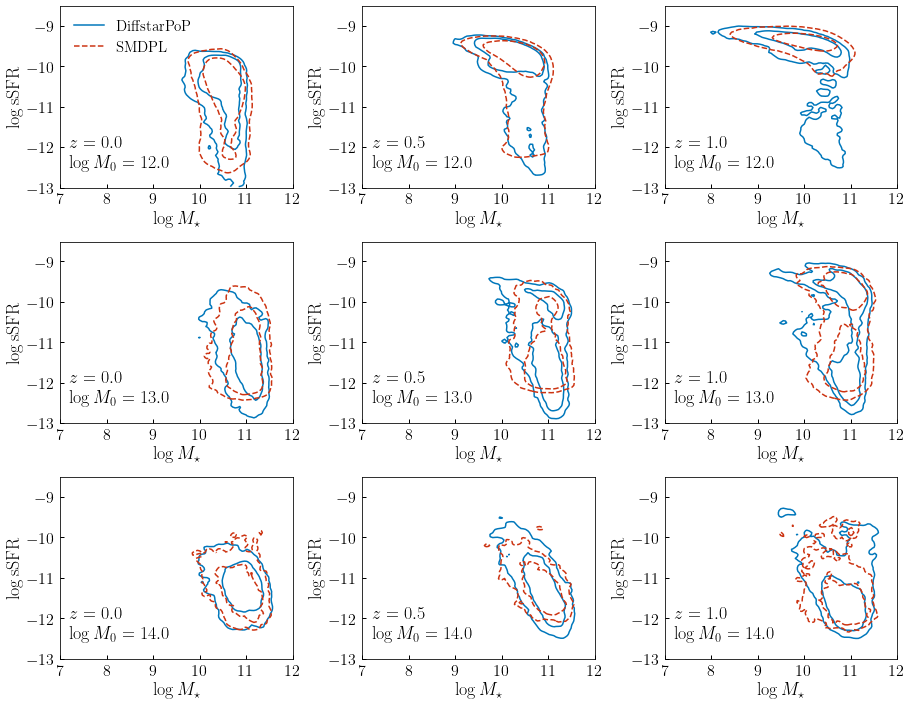

In [28]:
colors = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#CC3311", "#EE3377", '#882255', '#AA4499']

n_histories = int(1e4)
ran_key = jran.PRNGKey(0)

nbins_x = np.linspace(7, 12, 100)
nbins_y = np.linspace(-13, -8.5, 100)
        

fig, ax = plt.subplots(3, 3, figsize=(15,12))

for i, bin_id in enumerate([2,4,6]):
    for j, t_id in enumerate([7,11,19][::-1]):

        t0 = time.time()
        histories = draw_sfh_MIX(
            t_table,
            logm0_binmids[bin_id],
            halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id],
            p50.reshape(len(logm0_binmids),Nhalos)[bin_id],
            n_histories,
            ran_key,
            index_select,
            index_high,
            fstar_tdelay,
            init_guess[0:N_PDF_Q],
            init_guess[N_PDF_Q:N_PDF_Q+N_PDF_MS],
            init_guess[N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
            init_guess[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
        )
        
        weights = histories[4].copy()
        _params = np.zeros((Nhalos, 6))
        _params[:, 0] = np.log10(TODAY)
        _params[:, 1:3] = halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id][:, 0:2]
        _params[:, 3] = 3.5
        _params[:, 4:6] = halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id][:, 2:4]

        mah_histories = _calc_halo_history_vmap(lgt, *_params.T)
        
        _mask = (logmpeak > logm0_binmids[bin_id] - logm0_bin_widths[bin_id]) 
        _mask &= (logmpeak < logm0_binmids[bin_id] + logm0_bin_widths[bin_id])
        mah_histories_SMDPL = _calc_halo_history_vmap(lgt, *mah_params_arr[_mask].T)

        histories_SMDPL = sm_sfr_history_diffstar_scan_XsfhXmah_vmap(
            t_table,
            lgt,
            _get_dt_array(t_table),
            mah_params_arr[_mask][:, np.array([1,2,4,5])],
            u_fit_params_arr[_mask][:,np.array([0,1,2,4])],
            u_fit_params_arr[_mask][:,5:9],
            index_select,
            index_high,
            fstar_tdelay,
        )

        xdata = np.log10(histories[0][:, t_id])
        print(np.round(np.average(xdata, weights=np.array(weights)),2))
        ydata = np.log10(histories[1][:, t_id] / histories[0][:, t_id])
        
        density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax[i,j], smooth=True, weights=weights, level=0.68, colors=[colors[0]])
        density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax[i,j], smooth=True, weights=weights, level=0.95, colors=[colors[0]])

        xdata = np.log10(histories_SMDPL[0][:, t_id])
        ydata = np.log10(histories_SMDPL[1][:, t_id] / histories_SMDPL[0][:, t_id])
        print(np.round(np.mean(xdata),2))
        density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax[i,j], smooth=True, level=0.68, linestyles=['--'], colors=[colors[4]])
        density_contour(xdata, ydata, nbins_x, nbins_y, ax=ax[i,j], smooth=True, level=0.95, linestyles=['--'], colors=[colors[4]])
        t1 = time.time()
        print("time", t1-t0)
        ax[i,j].text(7.2, -12.5, r"$\log M_0 = %.1f$"%logm0_binmids[bin_id], fontsize=18)
        ax[i,j].text(7.2, -12.5+0.5, r"$z = %.1f$"%abs(z_table[t_id]), fontsize=18)
        ax[i,j].set_xlabel(r'$\log M_\star$')
        ax[i,j].set_ylabel(r'$\log \rm{sSFR}$')
        ax[i,j].set_xticks(np.arange(7,12.1,1))
        ax[i,j].set_yticks(np.arange(-13,-8.9,1))
        
fig.subplots_adjust(wspace=0.3, hspace=0.3)

legend_elements = [
    Line2D([0], [0], color=colors[0], ls='-', label=r'DiffstarPoP'),
    Line2D([0], [0], color=colors[4], ls='--', label=r'SMDPL'),
]
ax[0,0].legend(handles=legend_elements, loc=2)
fig.savefig("mstar_vs_ssfr_diffstarpop_smdpl.png", bbox_inches="tight", dpi=300)
        

In [185]:
xdata.shape

(2373,)

In [175]:
np.array(weights).shape

(2000,)

In [122]:
weights.shape, np.log10(histories[0][:, t_id]).shape

((20000,), (20000,))

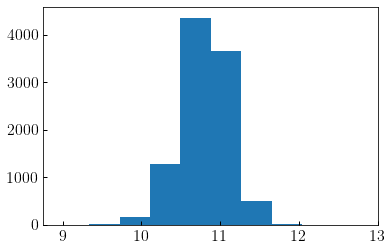

In [124]:
plt.hist(np.log10(histories[0][:, t_id]), weights=np.array(weights));

In [209]:
from diffstarpop.monte_carlo_diff_halo_population import sumstats_sfh_MIX_p50



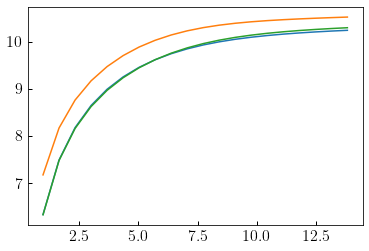

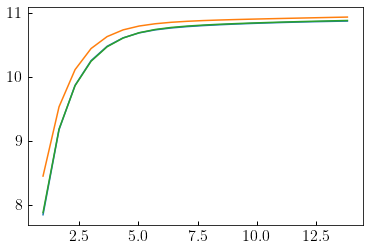

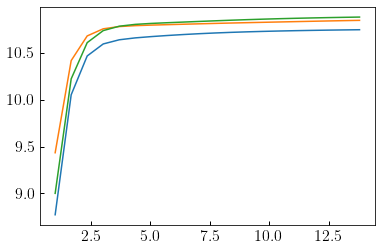

In [201]:
for i, bin_id in enumerate([2,4,6]):

    t0 = time.time()
    histories = draw_sfh_MIX(
        t_table,
        logm0_binmids[bin_id],
        halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id],
        p50.reshape(len(logm0_binmids),Nhalos)[bin_id],
        n_histories,
        ran_key,
        index_select,
        index_high,
        fstar_tdelay,
        init_guess[0:N_PDF_Q],
        init_guess[N_PDF_Q:N_PDF_Q+N_PDF_MS],
        init_guess[N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
        init_guess[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
    )

    weights = np.array(histories[4].copy())
    _params = np.zeros((Nhalos, 6))
    _params[:, 0] = np.log10(TODAY)
    _params[:, 1:3] = halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id][:, 0:2]
    _params[:, 3] = 3.5
    _params[:, 4:6] = halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id][:, 2:4]

    mah_histories = _calc_halo_history_vmap(lgt, *_params.T)

    _mask = (logmpeak > logm0_binmids[bin_id] - logm0_bin_widths[bin_id]) 
    _mask &= (logmpeak < logm0_binmids[bin_id] + logm0_bin_widths[bin_id])
    mah_histories_SMDPL = _calc_halo_history_vmap(lgt, *mah_params_arr[_mask].T)


    histories_SMDPL = sm_sfr_history_diffstar_scan_XsfhXmah_vmap(
        t_table,
        lgt,
        _get_dt_array(t_table),
        mah_params_arr[_mask][:, np.array([1,2,4,5])],
        u_fit_params_arr[_mask][:,np.array([0,1,2,4])],
        u_fit_params_arr[_mask][:,5:9],
        index_select,
        index_high,
        fstar_tdelay,
    )
    
    plt.plot(t_table, np.average(np.log10(histories[0]), weights=weights, axis=0))
    plt.plot(t_table, np.mean(np.log10(histories_SMDPL[0]), axis=0))
    plt.plot(t_table, np.array(MC_res_best_fit[0][bin_id]))
    plt.show()


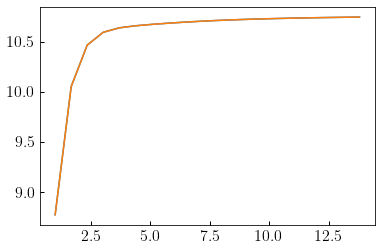

In [212]:
histories = draw_sfh_MIX(
    t_table,
    logm0_binmids[bin_id],
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id],
    p50.reshape(len(logm0_binmids),Nhalos)[bin_id],
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    init_guess[0:N_PDF_Q],
    init_guess[N_PDF_Q:N_PDF_Q+N_PDF_MS],
    init_guess[N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
    init_guess[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
)
    
_res = sumstats_sfh_MIX_p50(
    t_table,
    logm0_binmids[bin_id],
    halo_data_MC.reshape(len(logm0_binmids),Nhalos,4)[bin_id],
    p50.reshape(len(logm0_binmids),Nhalos)[bin_id],
    n_histories,
    ran_key,
    index_select,
    index_high,
    fstar_tdelay,
    init_guess[0:N_PDF_Q],
    init_guess[N_PDF_Q:N_PDF_Q+N_PDF_MS],
    init_guess[N_PDF_Q+N_PDF_MS:N_PDF_Q+N_PDF_MS+N_R_Q],
    init_guess[N_PDF_Q+N_PDF_MS+N_R_Q:N_PDF_Q+N_PDF_MS+N_R_Q+N_R_MS],
)

plt.plot(t_table, np.average(np.log10(histories[0]), weights=weights, axis=0))

plt.plot(t_table, np.array(_res[0]))


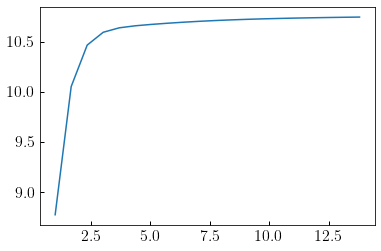

In [202]:
plt.plot(t_table, np.average(np.log10(histories[0]), weights=weights, axis=0))
plt.plot(t_table, np.average(np.log10(histories[0]), weights=weights, axis=0))